In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = "trajectory.h5ad"
# low dpi (dots per inch) yields small inline figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.2.3
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.11.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
brotli                      NA
certifi                     2024.02.02
cffi                        1.15.1
chardet                     4.0.0
charset_normalizer          2.0.4
cloudpickle                 2.2.1
colorama                    0.4.6
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.0
dask                        2023.6.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
exe

In [3]:
adata = sc.read_10x_mtx(
    "A2780/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache\A2780-matrix.h5ad


In [4]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [5]:
adata

AnnData object with n_obs × n_vars = 3870 × 33538
    var: 'gene_ids'

## QC

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=False)

In [8]:
mean_value_feature = adata.obs['n_genes_by_counts'].dropna().mean()
sd_value_feature = adata.obs['n_genes_by_counts'].dropna().std()

In [9]:
nFeature_Upper = mean_value_feature + 2 * sd_value_feature
nFeature_Lower = 200  # As per your fixed lower threshold

In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = adata[:, mito_genes].X.sum(axis=1) / adata.X.sum(axis=1) 

In [11]:
mean_value_perMito = adata.obs['percent_mito'].dropna().mean()
sd_value_perMito = adata.obs['percent_mito'].dropna().std()

In [12]:
perMito_Upper = mean_value_perMito + 2 * sd_value_perMito

In [13]:
adata = adata[
    (adata.obs['n_genes_by_counts'] > nFeature_Lower) & 
    (adata.obs['n_genes_by_counts'] < nFeature_Upper) & 
    (adata.obs['percent_mito'] < perMito_Upper)
]

In [15]:
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [14]:
adata

View of AnnData object with n_obs × n_vars = 3449 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'percent_mito'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
# this is not required and results will be comparable without it
adata.X = adata.X.astype("float64")

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

C:\Users\xch\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [17]:
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [19]:
adata.raw = adata

In [20]:
sc.pp.regress_out(adata, ["total_counts", "percent_mito"])

regressing out ['total_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:22)


In [21]:
sc.pp.scale(adata, max_value=10)

In [ ]:
# sc.pp.recipe_zheng17(adata)

In [24]:
sc.tl.pca(adata, svd_solver="arpack", n_comps = 100)

computing PCA
    with n_comps=100
    finished (0:00:03)


In [27]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [28]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.90645003 0.8977719  0.88113624 0.86304086 0.84296495
     0.8256674  0.81646144 0.8005357  0.78119224 0.76012456 0.7383466
     0.7208763  0.7082806  0.70714635]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [29]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_diffmap")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [30]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:05)


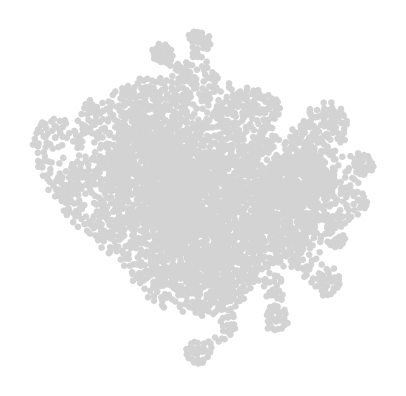

In [31]:
sc.pl.draw_graph(adata, legend_loc="on data")

In [32]:
sc.tl.louvain(adata, resolution=0.6)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [33]:
sc.tl.paga(adata, groups="louvain")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


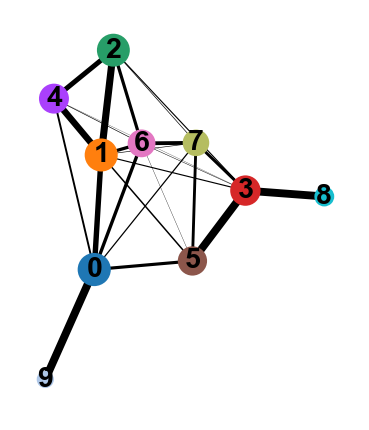

In [34]:
sc.pl.paga(adata, color=["louvain"])

In [35]:
adata.obs["louvain"].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [36]:
adata.obs["louvain_anno"] = adata.obs["louvain"]

In [37]:
sc.tl.paga(adata, groups="louvain_anno")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes: >

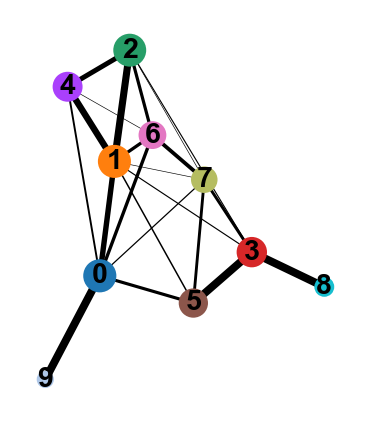

In [38]:
sc.pl.paga(adata, threshold=0.03, show=False)

In [39]:
sc.tl.draw_graph(adata, init_pos="paga")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:04)


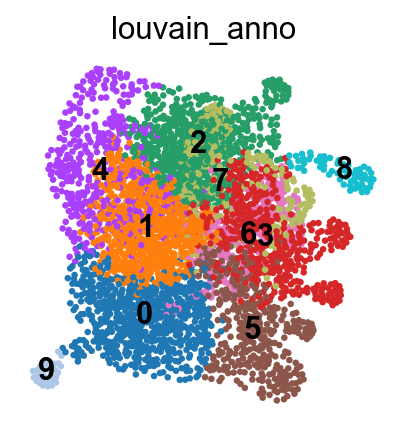

In [40]:
sc.pl.draw_graph(
    adata, color=["louvain_anno"], legend_loc="on data"
)

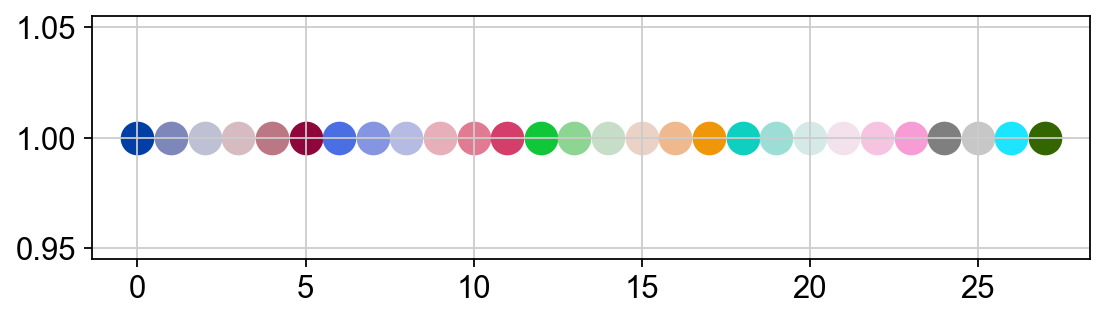

In [41]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [ ]:
sc.pl.draw_graph(adata, color=["louvain_anno", "dpt_pseudotime"], legend_loc="on data")